Found 1397 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Epoch 1/50
44/44 [==============================] - 32s 713ms/step - loss: 1.0337 - accuracy: 0.5991 - val_loss: 0.6310 - val_accuracy: 0.6215
Epoch 2/50
44/44 [==============================] - 31s 694ms/step - loss: 0.5310 - accuracy: 0.7266 - val_loss: 0.5723 - val_accuracy: 0.7477
Epoch 3/50
44/44 [==============================] - 31s 696ms/step - loss: 0.4611 - accuracy: 0.7845 - val_loss: 0.5453 - val_accuracy: 0.7196
Epoch 4/50
44/44 [==============================] - 31s 695ms/step - loss: 0.4556 - accuracy: 0.7838 - val_loss: 0.6312 - val_accuracy: 0.6869
Epoch 5/50
44/44 [==============================] - 30s 672ms/step - loss: 0.4597 - accuracy: 0.7802 - val_loss: 0.5675 - val_accuracy: 0.7523
Epoch 6/50
44/44 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8225
Validation accuracy reached 0.8177570104598999, which exceeds the threshold of 0.8. Stopping training.
44/44

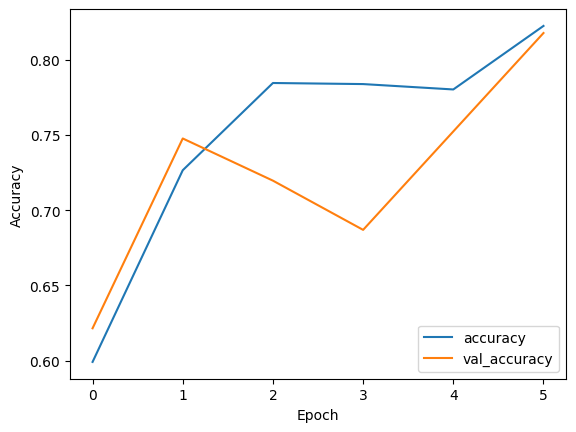

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Custom Callback to stop training when validation accuracy exceeds a certain threshold
class EarlyStoppingOnAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.80):
        super(EarlyStoppingOnAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is None:
            return

        if val_acc > self.threshold:
            print(f"\nValidation accuracy reached {val_acc}, which exceeds the threshold of {self.threshold}. Stopping training.")
            self.model.stop_training = True

# Image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   zoom_range=0.3,
                                   horizontal_flip=False,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255.0,
                                 rotation_range=10,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.1,
                                 zoom_range=0.3,
                                 horizontal_flip=False,
                                 fill_mode='nearest')

# Directories
train_data_path = "/content/drive/MyDrive/new_Dataset/train"
val_data_path = "/content/drive/MyDrive/new_Dataset/val"

# Training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

num_classes = train_generator.num_classes

# Load pre-trained VGG16 model without top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define custom early stopping callback
early_stopping_accuracy = EarlyStoppingOnAccuracy(threshold=0.80)

# Training the model with transfer learning
epochs_size = 50  # You can set a large number since early stopping will terminate training
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs_size, callbacks=[early_stopping_accuracy])

# Save the model
model.save("/content/drive/MyDrive/new_Dataset/oily_model_final8.h5")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 134ms/step


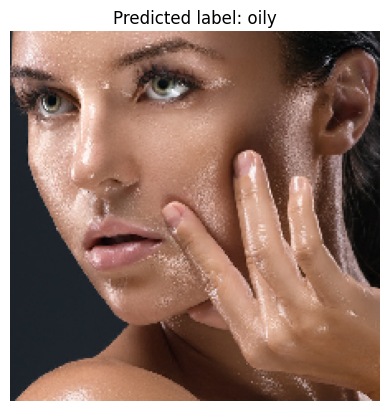

Predicted label: oily
percentage: 92.12802052497864 %
HIGH-OILYNESS


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = "/content/drive/MyDrive/new_Dataset/oily_model_final8.h5"
model = tf.keras.models.load_model(model_path)

# Define image file path
image_path = "/content/drive/MyDrive/dataset3/5CommonCausesForOilySkin.jpg"  # Change this to the path of your image

# Preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)

# Interpret predictions
class_names = {'non-oily': 0, 'oily': 1}  # Assuming these are your class names
predicted_class = np.argmax(predictions)
predicted_label = list(class_names.keys())[predicted_class]
confidence_level = predictions[0][predicted_class] * 100  # Confidence as percentage

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title('Predicted label: ' + predicted_label)
plt.show()

print("Predicted label:", predicted_label)
print("percentage:", confidence_level, "%")

if confidence_level > 75 and predicted_label == 'oily':
    print("HIGH-OILYNESS")
elif confidence_level <= 75 and predicted_label == 'oily':
    print("MID-OILYNESS")
elif predicted_label == 'non-oily':
    print("LOW-OILYNESS")
